<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/smic_data_augmentation/ExampleVolumeDataAugmentation_smic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Repositorios: https://github.com/AgaMiko/data-augmentation-review

CT Volume recognition: https://colab.research.google.com/drive/14vczr_vjxT9608bgHscaGZhV2e5-xLNQ?usp=sharing

In [ ]:
import os
import zipfile
import numpy as np
# import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = '/content/drive/MyDrive/TesisMScNataliaZartha/'
import numpy as np

X = np.load(ruta+'microexpstcnn_images_tr.npy')
t = np.load(ruta+'microexpstcnn_labels_tr.npy')



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
img = np.squeeze(X)/255.
lbl = t

x_train, x_val, y_train, y_val = train_test_split(img,lbl,test_size = 0.4,random_state = 123)
#x_train = img
#y_train = lbl #np.argmax(lbl,axis=1)
#x_val = img
#y_val = lbl #np.argmax(lbl,axis=1)

## Data augmentation

The Emotion sequence also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth (frames))`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def shift(volume):
    """Shift the volume"""

    def scipy_shift(volume):
        # shift volume
        volume = ndimage.shift(volume, [2, 2, 2], order=3, mode='constant', cval=0.0, prefilter=True)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_shift, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    # Shift volume
    #volume = shift(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Visualize an augmented CT scan.

Dimension of the Emotional sequence is: (64, 64, 18, 1)


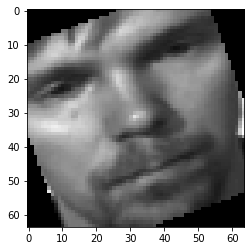

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the Emotional sequence is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")


Since an Emotional sequence scan have many slices, let's visualize a montage of the slices.

(1, 18, 64, 64)


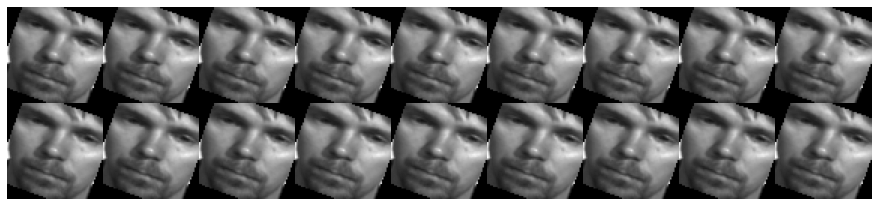

In [ ]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    print(data.shape)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(2, 9, 64, 64, image[:, :, :18])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [ ]:

def get_model(width=64, height=64, depth=18):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=350, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=100, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)


    #x = layers.Conv3D(filters=100, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=1)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=600, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=64, height=64, depth=18)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 18, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 62, 62, 16, 350)   9800      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 20, 5, 350)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 5, 350)    1400      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 18, 3, 100)    945100    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 9, 1, 100)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 1, 100)      400   

## Train model

In [ ]:
# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    #optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    ruta+"3d_image_classification_smic.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="loss", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 300
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
    #callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/300
48/48 - 37s - loss: 1.0866 - acc: 0.4105 - val_loss: 1.1029 - val_acc: 0.2344
Epoch 2/300
48/48 - 4s - loss: 1.0669 - acc: 0.4632 - val_loss: 1.1057 - val_acc: 0.2344
Epoch 3/300
48/48 - 4s - loss: 1.0704 - acc: 0.4737 - val_loss: 1.1081 - val_acc: 0.2344
Epoch 4/300
48/48 - 4s - loss: 1.0570 - acc: 0.4947 - val_loss: 1.1117 - val_acc: 0.2344
Epoch 5/300
48/48 - 4s - loss: 1.0664 - acc: 0.5053 - val_loss: 1.1159 - val_acc: 0.2344
Epoch 6/300
48/48 - 4s - loss: 1.0510 - acc: 0.4632 - val_loss: 1.1191 - val_acc: 0.2344
Epoch 7/300
48/48 - 4s - loss: 1.0265 - acc: 0.4737 - val_loss: 1.1217 - val_acc: 0.2344
Epoch 8/300
48/48 - 4s - loss: 1.0285 - acc: 0.5684 - val_loss: 1.1166 - val_acc: 0.2344
Epoch 9/300
48/48 - 4s - loss: 1.0390 - acc: 0.4947 - val_loss: 1.1057 - val_acc: 0.2188
Epoch 10/300
48/48 - 4s - loss: 1.0200 - acc: 0.5789 - val_loss: 1.0923 - val_acc: 0.3281
Epoch 11/300
48/48 - 4s - loss: 1.0216 - acc: 0.5368 - val_loss: 1.0698 - val_acc: 0.3906
Epoch 12/300
48/48

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

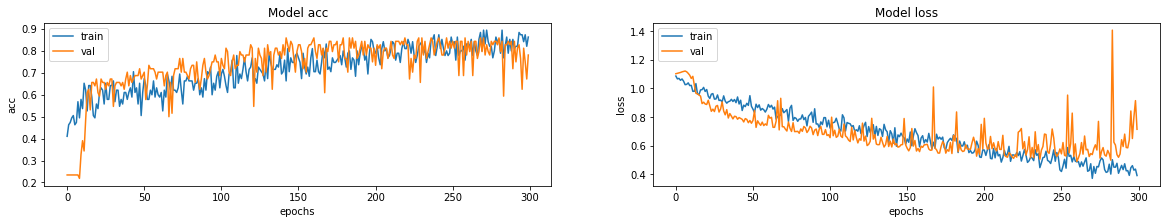

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single Emotional image scan

In [ ]:
# Load best weights.
model.load_weights(ruta+"3d_image_classification_smic.h5")


print(x_val.shape)
print(x_val[0].shape)

prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = prediction
class_names = ["Negativo", "Positivo","Sorpresa"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that Emotional sequence is %s"
        % ((100 * score), name)
    )

print('Real Label: ',y_val[0])

(64, 64, 64, 18)
(64, 64, 18)
This model is 9.05 percent confident that Emotional sequence is Negativo
This model is 1.20 percent confident that Emotional sequence is Positivo
This model is 89.75 percent confident that Emotional sequence is Sorpresa
Real Label:  [0. 0. 1.]


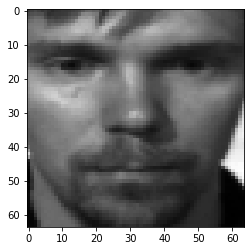

In [ ]:
plt.imshow(np.squeeze(x_val[0,:, :, 10]), cmap="gray")

Acc:  0.84375


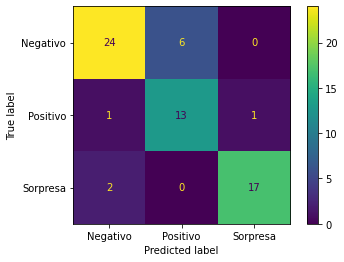

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
dataTest = np.expand_dims(x_val[0], axis=0)
y_est = model.predict(x_val)

acc = accuracy_score(np.argmax(y_val,axis=1),np.argmax(y_est,axis=1))
print('Acc: ',acc)
cMat = confusion_matrix(np.argmax(y_val,axis=1),np.argmax(y_est,axis=1))
ax = ConfusionMatrixDisplay(cMat,class_names)
ax.plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, hamming_loss, jaccard_similarity_score, log_loss, zero_one_loss, matthews_corrcoef, confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc

def evaluation_analysis(true_label,predicted): 
    '''
    return all metrics results
    '''
    print("accuracy",accuracy_score(true_label, predicted))
    print("f1 score macro",f1_score(true_label, predicted, average='macro'))     
    print("f1 score micro",f1_score(true_label, predicted, average='micro'))
    print("precision score",precision_score(true_label, predicted, average='macro'))
    print("recall score (Sensibilidad)",recall_score(true_label, predicted, average='macro'))
    print("hamming_loss",hamming_loss(true_label, predicted))
    print("classification_report", classification_report(true_label, predicted))
    print("jaccard_similarity_score", jaccard_similarity_score(true_label, predicted))
    #print("log_loss", log_loss(true_label, predicted))
    print("zero_one_loss", zero_one_loss(true_label, predicted))
    #print("AUC&ROC",roc_auc_score(true_label, predicted))
    print("matthews_corrcoef", matthews_corrcoef(true_label, predicted)) 


evaluation_analysis(np.argmax(y_val,axis=1),np.argmax(y_est,axis=1))

accuracy 0.84375
f1 score macro 0.841910021476585
f1 score micro 0.84375
precision score 0.8391812865497075
recall score (Sensibilidad) 0.8538011695906432
hamming_loss 0.15625
classification_report               precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.68      0.87      0.76        15
           2       0.94      0.89      0.92        19

    accuracy                           0.84        64
   macro avg       0.84      0.85      0.84        64
weighted avg       0.86      0.84      0.85        64

jaccard_similarity_score 0.84375
zero_one_loss 0.15625
matthews_corrcoef 0.7631091808504358


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#ROC and Precision-Recall curves

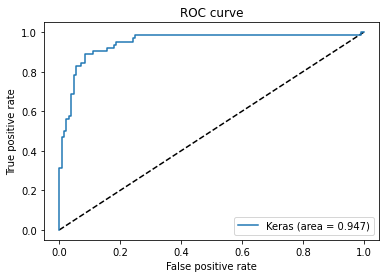

In [ ]:
#https://webmonkez.com/questions/1637057/como-encontrar-la-curva-roc-y-la-puntuacion-auc-del-modelo-cnn-keras

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val.ravel(), y_est.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Save model as json string

In [ ]:
import datetime
current_date = datetime.datetime.today().strftime("%Y-%m-%d_%H:%M:%S")

path = ruta + 'model/'
model.save(path +  'model_'+current_date) 


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TesisMScNataliaZartha/model/model_2021-09-18_02:40:42/assets
